In [5]:
import sys
from pathlib import Path

# Add project root to Python path so `src` is importable
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import US_BANK_TICKERS
from src.data import DataConfig, download_prices, log_returns, sanity_report


In [8]:
cfg = DataConfig(
    start="2015-01-01",
    cache_name="us_banks_adjclose.parquet"
)

prices = download_prices(
    US_BANK_TICKERS,
    cfg,
    force_refresh=True  # set True only if you want to re-download
)

prices.tail(), prices.shape


(Ticker            BAC          BK           C         COF          GS  \
 Date                                                                    
 2026-01-02  55.950001  117.040001  118.699997  247.929993  914.340027   
 2026-01-05  56.889999  121.040001  123.300003  250.509995  948.440002   
 2026-01-06  57.250000  121.309998  122.500000  257.940002  955.469971   
 2026-01-07  55.639999  120.449997  121.370003  253.250000  941.020020   
 2026-01-08  56.299999  120.330002  121.614998  255.220001  940.607483   
 
 Ticker             JPM          MS         PNC         STT        TFC  \
 Date                                                                    
 2026-01-02  324.018433  181.899994  211.460007  129.070007  49.740002   
 2026-01-05  332.540009  186.539993  215.800003  133.009995  50.480000   
 2026-01-06  334.609985  187.750000  218.039993  134.320007  51.180000   
 2026-01-07  326.989990  184.789993  216.270004  132.449997  50.580002   
 2026-01-08  330.559998  185.360001 

In [9]:
sanity_report(prices)


{'rows': 2771,
 'cols': 12,
 'start': '2015-01-02',
 'end': '2026-01-08',
 'tickers': ['BAC',
  'BK',
  'C',
  'COF',
  'GS',
  'JPM',
  'MS',
  'PNC',
  'STT',
  'TFC',
  'USB',
  'WFC'],
 'missing_frac_max': 0.0}

In [10]:
returns = log_returns(prices)
returns.describe().T[["mean", "std", "min", "max"]]


,mean,std,min,max
Ticker,,,,
BAC,0.000497,0.019355,-0.167204,0.163786
BK,0.000492,0.016958,-0.156693,0.145109
C,0.000398,0.020639,-0.214415,0.165381
COF,0.000480,0.022828,-0.272783,0.171887
GS,0.000648,0.018303,-0.135880,0.161952
JPM,0.000708,0.017079,-0.162106,0.165620
MS,0.000673,0.019668,-0.169603,0.180403
PNC,0.000443,0.018310,-0.173165,0.121717
STT,0.000299,0.020499,-0.209811,0.201464


Returns look broadly similar across banks, but tail risk and volatility differ enough that not all pairs are equally safe.

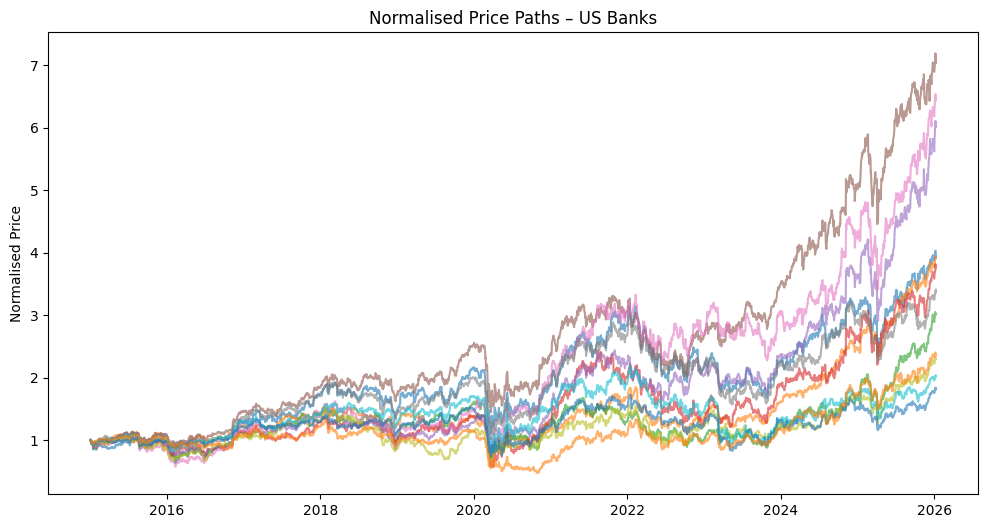

In [11]:
norm_prices = prices / prices.iloc[0]

plt.figure(figsize=(12, 6))
for col in norm_prices.columns:
    plt.plot(norm_prices.index, norm_prices[col], alpha=0.6)

plt.title("Normalised Price Paths – US Banks")
plt.ylabel("Normalised Price")
plt.show()


### Observations from normalised price paths (US banks)

1. The majority of US banks exhibit broadly similar long-run behaviour, particularly during rare events such as the 2020 COVID drawdown, where prices move sharply and synchronously.

2. Despite overall co-movement, there is significant cross-sectional dispersion over longer horizons. Certain banks (e.g. large investment banks) have structurally outperformed others, showing that price levels diverge over time even when short-term returns are correlated.

3. The post-2020 period shows increased divergence across banks, suggesting that relative performance is regime-dependent and influenced by changes in interest rate environments, business models, and balance sheet sensitivity.

4. These observations suggest that high correlation alone does not imply stable mean-reversion in price levels, as spreads between banks can drift persistently over multi-year horizons.

5. Any pairs trading strategy in this universe must therefore explicitly account for structural breaks and regime changes, rather than assuming permanent equilibrium relationships.


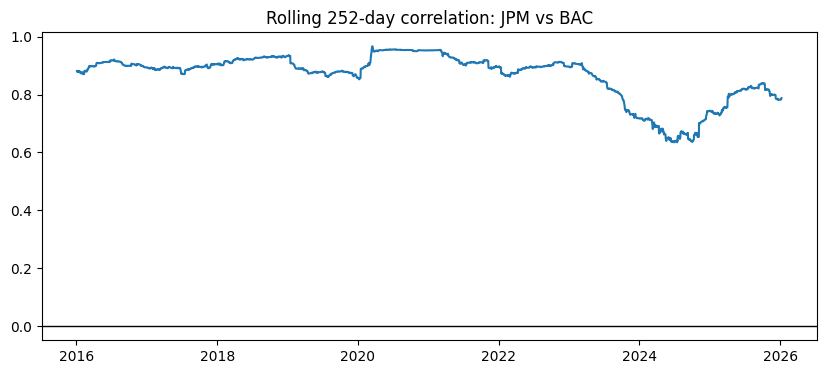

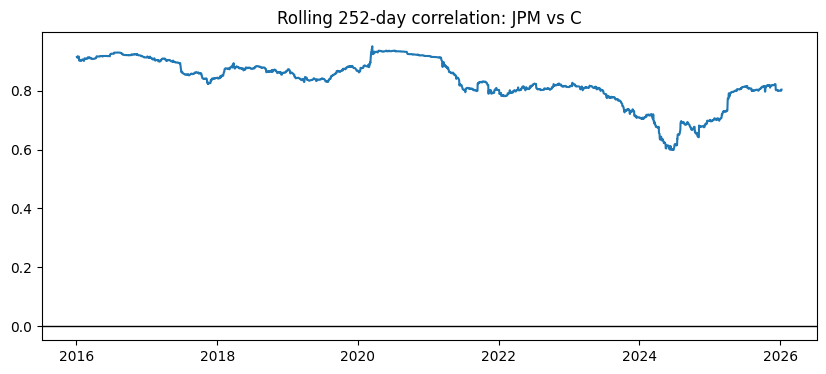

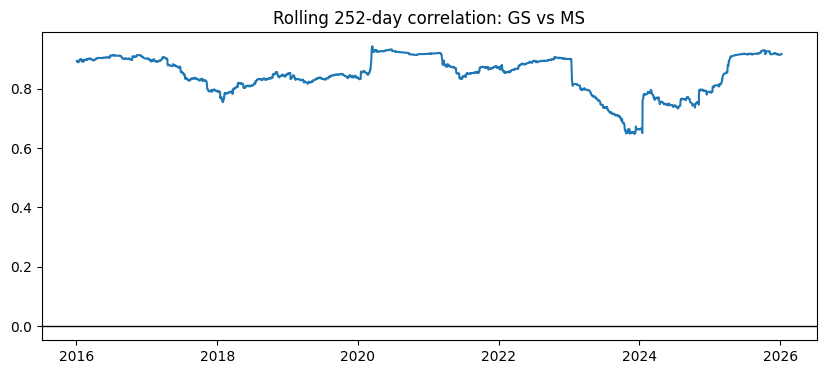

In [12]:
def plot_rolling_corr(a, b, window=252):
    rc = returns[a].rolling(window).corr(returns[b])
    plt.figure(figsize=(10, 4))
    plt.plot(rc)
    plt.axhline(0, color="black", lw=1)
    plt.title(f"Rolling {window}-day correlation: {a} vs {b}")
    plt.show()

plot_rolling_corr("JPM", "BAC")
plot_rolling_corr("JPM", "C")
plot_rolling_corr("GS", "MS")


### Observations from rolling correlations

1. JPM–BAC exhibits persistently high correlation over long periods, suggesting a strong structural relationship; however, correlation deteriorates meaningfully after 2022, indicating regime sensitivity.

2. JPM–C shows weaker and less stable correlation, particularly during stress periods, highlighting that not all large banks respond uniformly to market conditions.

3. GS–MS demonstrates high long-run correlation with sharp but temporary breakdowns, consistent with similar business models experiencing episodic shocks rather than permanent divergence.

4. Across all pairs, correlations tend to spike during systemic crises and weaken during regime transitions, suggesting that correlation alone is insufficient to guarantee stable mean-reversion in price levels.

5. These results motivate the need for cointegration testing and stability analysis, as well as explicit consideration of regime-dependent failure modes in any pairs trading framework.


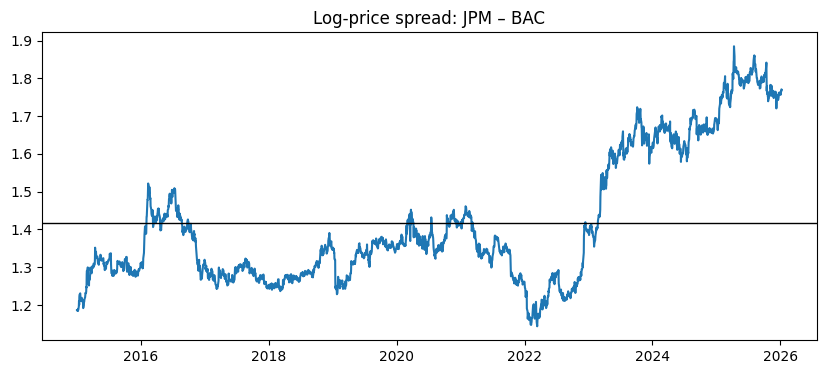

In [14]:
pair_a, pair_b = "JPM", "BAC"

spread = np.log(prices[pair_a]) - np.log(prices[pair_b])

plt.figure(figsize=(10, 4))
plt.plot(spread)
plt.title(f"Log-price spread: {pair_a} – {pair_b}")
plt.axhline(spread.mean(), color="black", lw=1)
plt.show()


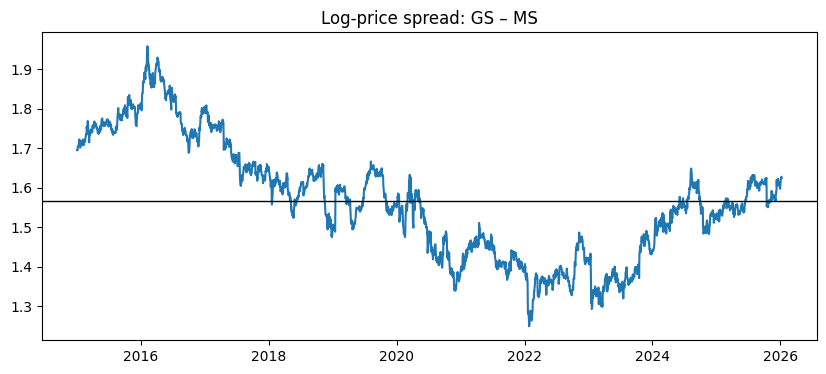

In [15]:
pair_a, pair_b = "GS", "MS"

spread = np.log(prices[pair_a]) - np.log(prices[pair_b])

plt.figure(figsize=(10, 4))
plt.plot(spread)
plt.title(f"Log-price spread: {pair_a} – {pair_b}")
plt.axhline(spread.mean(), color="black", lw=1)
plt.show()



### Observations from log-price spreads

1. The JPM–BAC log-price spread exhibits persistent drift over time, particularly after 2022, indicating a non-stationary relationship driven by structural divergence rather than temporary mispricing.

2. Despite high return correlation, the JPM–BAC spread does not revert to a stable long-run mean, highlighting that correlation alone is insufficient for identifying tradable pairs.

3. In contrast, the GS–MS log-price spread appears more bounded, with visible episodes of divergence followed by reversion, consistent with a shared business model and episodic shocks rather than permanent structural change.

4. These observations suggest that viable pairs trading candidates require not only high correlation, but also evidence of a stable long-run equilibrium in price levels.

5. This motivates formal cointegration testing and stability analysis to distinguish between spurious correlation and economically meaningful mean-reverting relationships.


Observations from data exploration

Correlations between large US banks are:
Generally high (often ~0.8–0.95 on a 252d window) for the big names, especially within similar business models (e.g., GS–MS; JPM–BAC). Regionals / special cases tend to be a bit lower and more erratic.

Correlations appear to be (stable / regime-dependent) because:
Regime-dependent. You can see correlations spike in systemic stress (around 2020) and deteriorate around regime transitions (notably post-2022 into 2024). The JPM–BAC and JPM–C rolling correlations both fall materially from their earlier highs, which is exactly what you’d expect if macro/rates/business-mix sensitivity changes.

JPM–BAC spread appears to:
Drift rather than mean-revert. It shows a persistent upward trend, with a clear structural break around 2022–2023. That’s “high return correlation but non-stationary level relationship” in one picture.

One pair that looks promising visually:
GS–MS. The spread looks more bounded with visible episodes of divergence followed by reversion, consistent with similar revenue drivers and an equilibrium relationship that might be stable.

One pair that clearly does NOT look mean-reverting:
JPM–BAC (based on your spread plot). Even though returns are correlated, the level relationship drifts, which is toxic for naive mean-reversion trading.